In [1]:
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Times New Roman'

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

import settings

In [3]:
"""Set up API"""
consumer_key = settings.twitter_consumer_key
consumer_key_secret = settings.twitter_consumer_key_secret
access_token = settings.twitter_access_token
access_token_secret = settings.twitter_access_token_secret

auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)


user = api.me()
print(user)

User(_api=<tweepy.api.API object at 0x00000262B30FE358>, _json={'id': 1311522424631054337, 'id_str': '1311522424631054337', 'name': 'Victiny', 'screen_name': 'Victiny8', 'location': '', 'profile_location': None, 'description': '', 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 0, 'friends_count': 0, 'listed_count': 0, 'created_at': 'Thu Oct 01 04:24:57 +0000 2020', 'favourites_count': 0, 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'verified': False, 'statuses_count': 0, 'lang': None, 'contributors_enabled': False, 'is_translator': False, 'is_translation_enabled': False, 'profile_background_color': 'F5F8FA', 'profile_background_image_url': None, 'profile_background_image_url_https': None, 'profile_background_tile': False, 'profile_image_url': 'http://pbs.twimg.com/profile_images/1312814198141997056/0RrgAkkP_normal.jpg', 'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1312814198141997056/0RrgAkkP_normal.jpg

In [4]:
"""Extract tweets"""
tweets = []

for page in range(1, 20):
    # user_timeline gets the 20 most recent statuses posted from the authenticating user or the user specified
    # id, user_id, screen_name: specifiy the user
    # since_id (statuses greater than, more recent), max_id (smaller, older)
    # count: the number of reslts to try and retrieve per page
    tweets.extend(api.user_timeline(screen_name="realDonaldTrump", count=200, page=page))

print("Number of tweets extracted: {}. \n".format(len(tweets)))

Number of tweets extracted: 3183. 



In [5]:
"""Check most recent tweets"""
for idx, tweet in enumerate(tweets[:5]):
    print(idx, tweet.text, '\n')

0 RT @RepMattGaetz: Democrats and the media told us over and over again the Bidens were being falsely accused of improper behavior with Buris… 

1 https://t.co/DZpnte42vi 

2 https://t.co/2mkecBJH46 

3 https://t.co/t7MUFQi3G2 

4 RT @DanScavino: 🚨HAPPENING NOW‼️
10/16/20–Macon, GA! MAGA🇺🇸🦅
🌐https://t.co/zqgeZML9Hf https://t.co/pY20ZQ6sUz 



In [6]:
"""Exclude the retweets"""
own_tweets = [tweet for tweet in tweets if tweet.retweeted == False and "RT @" not in tweet.text]

for idx, own_tweet in enumerate(own_tweets[:5]):
    print(idx, own_tweet.text, '\n') 

0 https://t.co/DZpnte42vi 

1 https://t.co/2mkecBJH46 

2 https://t.co/t7MUFQi3G2 

3 THANK YOU MACON, GEORGIA!
https://t.co/jjnVrVgQWY 

4 Getting ready to land in Macon, Georgia. Another giant crowd. See you soon! 



In [8]:
"""Store the data into a pd.DataFrame"""
df  = pd.DataFrame([[ot.created_at, 
                     ot.text, 
                     len(ot.text), 
                     ot.id, 
                     ot.favorite_count, 
                     ot.retweet_count] for ot in own_tweets],
                    columns=['Date', 'Tweet', 'Length', 'ID', 'Likes', 'Retweets'])
df.head()

,Date,Tweet,Length,ID,Likes,Retweets
0,2020-10-17 02:06:10,https://t.co/DZpnte42vi,23,1317285747318169600,40874,9908
1,2020-10-17 02:05:54,https://t.co/2mkecBJH46,23,1317285676904181760,27133,6627
2,2020-10-17 02:05:27,https://t.co/t7MUFQi3G2,23,1317285567445397504,31544,7417
3,2020-10-17 01:19:11,"THANK YOU MACON, GEORGIA!\nhttps://t.co/jjnVrV...",49,1317273920869928961,69666,15254
4,2020-10-16 22:53:54,"Getting ready to land in Macon, Georgia. Anoth...",75,1317237360094965760,154738,21951


In [9]:
""" Which tweet gets most likes?"""
tweet_most_likes = df[df.Likes == df.Likes.max()]
tweet_most_likes

,Date,Tweet,Length,ID,Likes,Retweets
364,2020-10-02 04:54:06,"Tonight, @FLOTUS and I tested positive for COV...",140,1311892190680014849,1880849,413121


In [10]:
top5_likes = df.sort_values(by=['Likes'], ascending=False)
top5_likes[:5]

,Date,Tweet,Length,ID,Likes,Retweets
364,2020-10-02 04:54:06,"Tonight, @FLOTUS and I tested positive for COV...",140,1311892190680014849,1880849,413121
362,2020-10-03 03:31:34,"Going welI, I think! Thank you to all. LOVE!!!",46,1312233807991496704,1223390,140110
363,2020-10-02 22:31:56,https://t.co/B4H105KVSs,23,1312158400352972800,762011,131356
359,2020-10-03 22:51:58,https://t.co/gvIPuYtTZG,23,1312525833505058816,717810,146391
360,2020-10-03 17:46:48,OUR GREAT USA WANTS &amp; NEEDS STIMULUS. WORK...,83,1312449034154504192,652092,93699


In [11]:
df.Likes.describe()

count    1.699000e+03
mean     9.893036e+04
std      9.791216e+04
min      0.000000e+00
25%      4.392400e+04
50%      7.147600e+04
75%      1.217770e+05
max      1.880849e+06
Name: Likes, dtype: float64

Text(0, 0.5, 'Frenquency')

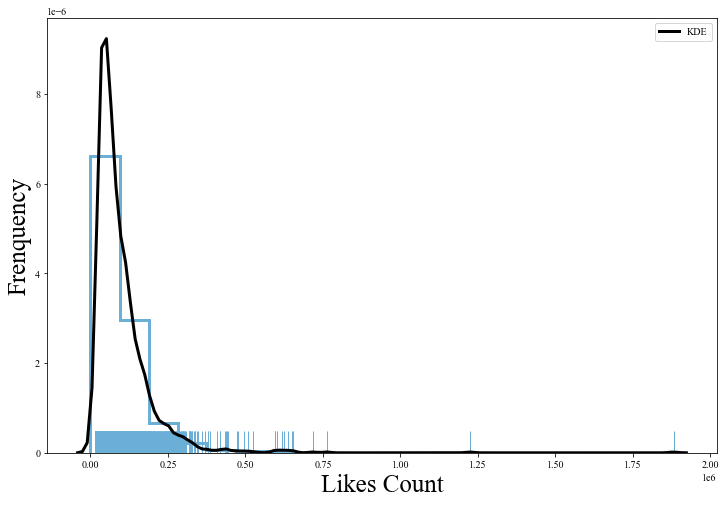

In [12]:
"""Histogram of likes count"""
plt.figure(figsize=(12, 8))
cmap = plt.get_cmap('tab20c')
sns.distplot(df.Likes, rug=True, rug_kws={"color": cmap(1)}, bins=20,
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": cmap(1)})
plt.xlabel('Likes Count', fontsize=25)
plt.ylabel('Frenquency', fontsize=25)

In [13]:
"""Analyzing the tweets sentiment"""
vader = SentimentIntensityAnalyzer()
df['Sentiment'] = df['Tweet'].apply(lambda tweet: vader.polarity_scores(tweet)['compound'])
df['Date'] = pd.to_datetime(df['Date']).dt.date
df.head()

,Date,Tweet,Length,ID,Likes,Retweets,Sentiment
0,2020-10-17,https://t.co/DZpnte42vi,23,1317285747318169600,40874,9908,0.0000
1,2020-10-17,https://t.co/2mkecBJH46,23,1317285676904181760,27133,6627,0.0000
2,2020-10-17,https://t.co/t7MUFQi3G2,23,1317285567445397504,31544,7417,0.0000
3,2020-10-17,"THANK YOU MACON, GEORGIA!\nhttps://t.co/jjnVrV...",49,1317273920869928961,69666,15254,0.5461
4,2020-10-16,"Getting ready to land in Macon, Georgia. Anoth...",75,1317237360094965760,154738,21951,0.4199


Text(0.15, -0.07, 'Negative')

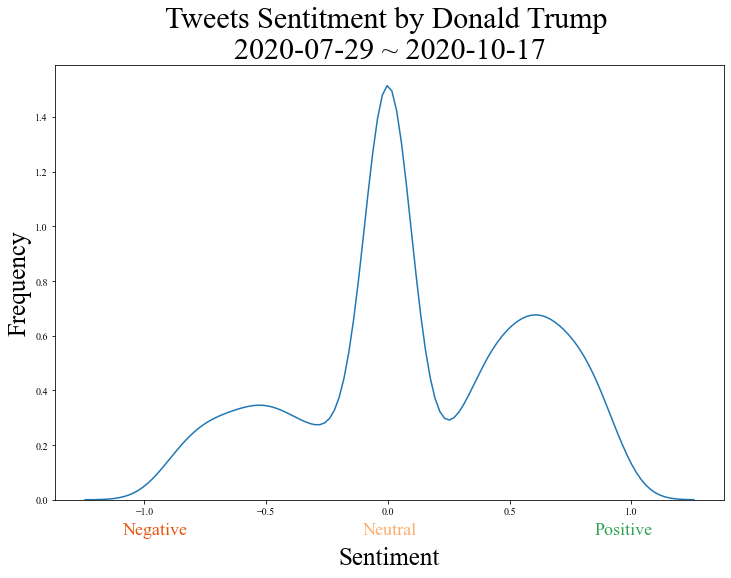

In [14]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
sns.distplot(df.Sentiment, hist=False)
plt.xlabel('Sentiment', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
plt.title('Tweets Sentitment by Donald Trump \n' + df.Date.iloc[-1].strftime("%Y-%m-%d") + ' ~ ' + df.Date.iloc[0].strftime("%Y-%m-%d"),
          fontsize=30)
ax.xaxis.labelpad = 30
ax.annotate('Positive', (0.85, -0.07), xycoords='axes fraction', va='center', ha='center',fontsize=18, color=cmap(8))
ax.annotate('Neutral', (0.5, -0.07), xycoords='axes fraction', va='center', ha='center',fontsize=18, color=cmap(6))
ax.annotate('Negative', (0.15, -0.07), xycoords='axes fraction', va='center', ha='center',fontsize=18, color=cmap(4))

In [15]:
fig.savefig('C:/Users/Victiny/Python_Project/Tweet_Analysis_Visualization/gallery/tweets_dtrump_sentiment_hist.png', bbox_inches='tight', pad_inches=0.1)

In [16]:
"""Average daily sentiment """
date_df = df.groupby(['Date']).mean().reset_index()
date_df.head()

,Date,Length,ID,Likes,Retweets,Sentiment
0,2020-07-29,92.333333,1.288594e+18,133148.666667,34224.166667,0.133300
1,2020-07-30,122.133333,1.288895e+18,142418.000000,32390.333333,0.089220
2,2020-07-31,116.750000,1.289264e+18,96759.750000,26560.083333,0.237817
3,2020-08-01,113.076923,1.289547e+18,108902.384615,24220.923077,0.091969
4,2020-08-02,110.583333,1.289839e+18,81396.583333,16357.458333,0.143517


C:\Users\Victiny\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


Text(0.0, 0.01, 'Negative')

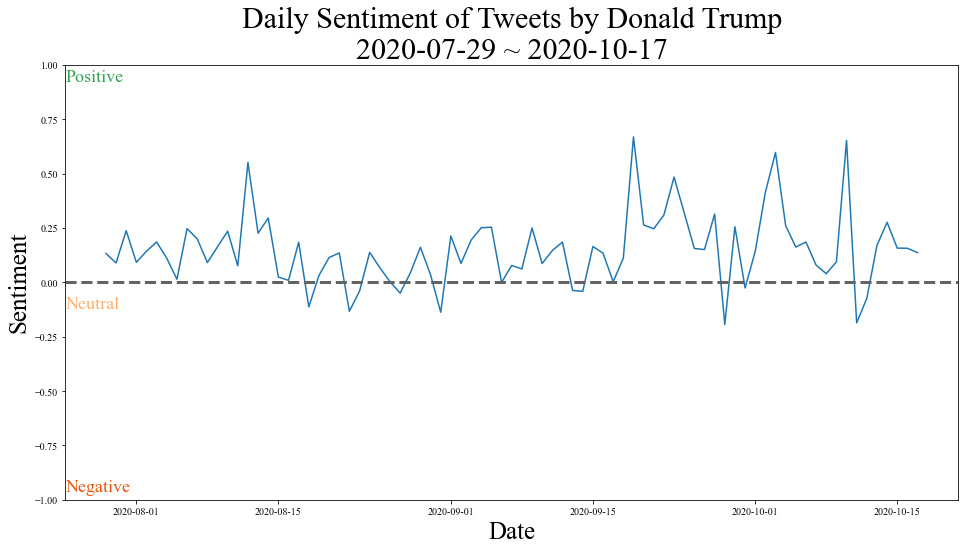

In [19]:
fig = plt.figure(figsize=(16, 8))
sns.lineplot(data=date_df, x='Date', y='Sentiment')
plt.axhline(y=0, color=cmap(16), lw=3, linestyle='--')
plt.ylim(-1, 1)
plt.xlabel('Date', fontsize=25)
plt.ylabel('Sentiment', fontsize=25)
plt.title('Daily Sentiment of Tweets by Donald Trump\n' + df.Date.iloc[-1].strftime("%Y-%m-%d") + ' ~ ' + df.Date.iloc[0].strftime("%Y-%m-%d"), fontsize=30)
ax = fig.add_subplot()
ax.annotate('Positive', (0., 0.99), xycoords='axes fraction', va='top', ha='left',fontsize=18, color=cmap(8))
ax.annotate('Neutral', (0., 0.45), xycoords='axes fraction', va='center', ha='left',fontsize=18, color=cmap(6))
ax.annotate('Negative', (0., 0.01), xycoords='axes fraction', va='bottom', ha='left',fontsize=18, color=cmap(4))

In [20]:
fig.savefig('C:/Users/Victiny/Python_Project/Tweet_Analysis_Visualization/gallery/tweets_dtrump_sentiment_daily.png', bbox_inches='tight', pad_inches=0.1)

(-0.5, 399.5, 199.5, -0.5)

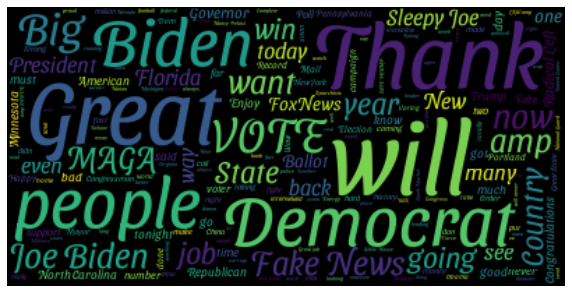

In [21]:
"""Make a wordcloud"""
text_all = " ".join(text for text in df.Tweet)

stopwords = set(STOPWORDS)
stopwords.update(['HTTPS', 'CO'])

# fp = 'arial'
fp = 'SansitaSwashed-VariableFont_wght.ttf'
wordcloud  = WordCloud(stopwords=stopwords, background_color='black', #colormap=plt.get_cmap('bwr'), 
                       font_path=fp).generate(text_all)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
plt.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')

In [22]:
fig.savefig('C:/Users/Victiny/Python_Project/Tweet_Analysis_Visualization/gallery/wordcloud_tweets_dtrump.png', bbox_inches='tight', pad_inches=0.1)

(-0.5, 499.5, 499.5, -0.5)

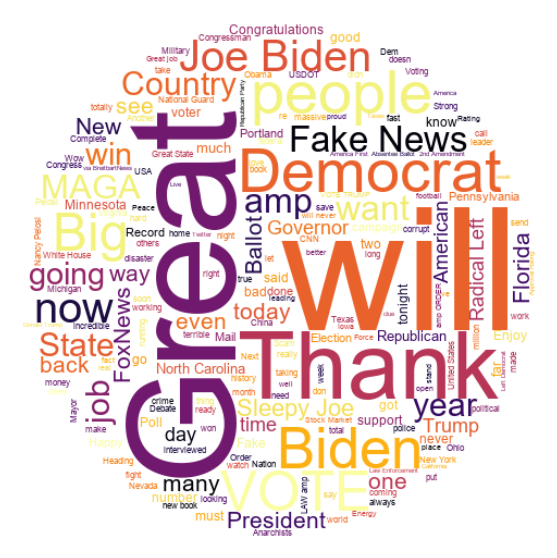

In [23]:
"""Masked wordcloud"""
x, y = np.ogrid[:500, :500]
mask = (x-250)**2 + (y-250)**2 > 240**2
mask = 255*mask.astype(int)

fp='arial'
wc_mask = WordCloud(stopwords=stopwords, background_color='white', colormap=plt.get_cmap('inferno'), 
                       font_path=fp, mask=mask).generate(text_all)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
plt.imshow(wc_mask, interpolation='bilinear')
ax.axis('off')

In [24]:
fig.savefig('C:/Users/Victiny/Python_Project/Tweet_Analysis_Visualization/gallery/wordcloud_tweets_dtrump_mask_circle.png', bbox_inches='tight', pad_inches=0.1)

(1000, 1000, 3)

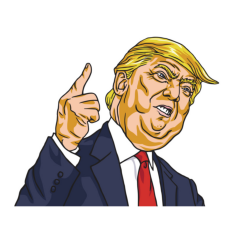

In [25]:
dtrump = np.array(Image.open('C:/Users/Victiny/Python_Project/Tweet_Analysis_Visualization/donald_trump.jpg'))
dtrump = dtrump[:1000,:1000,:]
plt.imshow(dtrump)
plt.axis('off')
dtrump.shape

(-0.5, 999.5, 999.5, -0.5)

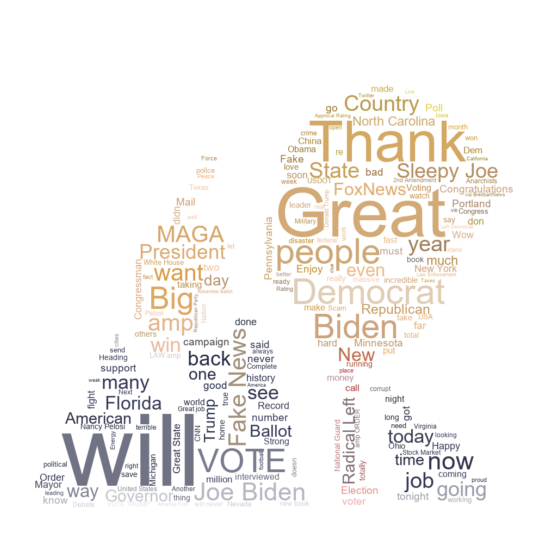

In [26]:
wc_dtrump = WordCloud(stopwords=stopwords, background_color='white', colormap=plt.get_cmap('inferno'), 
                       font_path=fp, mask=dtrump).generate(text_all)

# create colorung from image
dtrump_colors = ImageColorGenerator(dtrump)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
plt.imshow(wc_dtrump.recolor(color_func=dtrump_colors), interpolation='bilinear')
ax.axis('off')

In [27]:
fig.savefig('C:/Users/Victiny/Python_Project/Tweet_Analysis_Visualization/gallery/wordcloud_tweets_dtrump_mask_dtrump.png', bbox_inches='tight', pad_inches=0.1)